In [1]:
import os

def total_files(folder_path):
    num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    return num_files

train_files_healthy = "Train/Train/Healthy"
train_files_powdery = "Train/Train/Powdery"
train_files_rust = "Train/Train/Rust"

test_files_healthy = "Test/Test/Healthy"
test_files_powdery = "Test/Test/Powdery"
test_files_rust = "Test/Test/Rust"

valid_files_healthy = "Validation/Validation/Healthy"
valid_files_powdery = "Validation/Validation/Powdery"
valid_files_rust = "Validation/Validation/Rust"

print("Number of healthy leaf images in training set", total_files(train_files_healthy))
print("Number of powder leaf images in training set", total_files(train_files_powdery))
print("Number of rusty leaf images in training set", total_files(train_files_rust))

print("\n")

print("Number of healthy leaf images in test set", total_files(test_files_healthy))
print("Number of powder leaf images in test set", total_files(test_files_powdery))
print("Number of rusty leaf images in test set", total_files(test_files_rust))

print("\n")

print("Number of healthy leaf images in validation set", total_files(valid_files_healthy))
print("Number of powder leaf images in validation set", total_files(valid_files_powdery))
print("Number of rusty leaf images in validation set", total_files(valid_files_rust))

Number of healthy leaf images in training set 458
Number of powder leaf images in training set 430
Number of rusty leaf images in training set 434


Number of healthy leaf images in test set 50
Number of powder leaf images in test set 50
Number of rusty leaf images in test set 50


Number of healthy leaf images in validation set 20
Number of powder leaf images in validation set 20
Number of rusty leaf images in validation set 20


In [9]:
import os

# 1) Ensure we’re in the project root:
os.chdir(r"C:\Users\Asus\OneDrive\Desktop\Ai Projectele\Capstone_Fixed_Notebooks")
print("Working directory:", os.getcwd())

# 2) List top‑level contents
print("\nContents of project root:")
for item in os.listdir("."):
    print(" ", item)

# 3) List dataset structure
print("\nContents of dataset/:")
print(" ", os.listdir("dataset"))

# 4) Drill into Train and its subfolders
for sub in ["Train", os.path.join("Train","Train"), os.path.join("Train","Train","Healthy")]:
    exists = os.path.exists(os.path.join("dataset", sub))
    print(f"\nPath dataset/{sub!s} exists? {exists}")
    if exists:
        print(" Contents:", os.listdir(os.path.join("dataset", sub)))

# 5) Same for Test
for sub in ["Test", os.path.join("Test","Test"), os.path.join("Test","Test","Healthy")]:
    exists = os.path.exists(os.path.join("dataset", sub))
    print(f"\nPath dataset/{sub!s} exists? {exists}")
    if exists:
        print(" Contents:", os.listdir(os.path.join("dataset", sub)))


Working directory: C:\Users\Asus\OneDrive\Desktop\Ai Projectele\Capstone_Fixed_Notebooks

Contents of project root:
  .ipynb_checkpoints
  best_model.h5
  dataset
  logs
  ResNet501_fixed.ipynb
  ResNet50_fixed.ipynb
  Sequential_fixed.ipynb

Contents of dataset/:
  ['AI Project ele.py', 'Test', 'Train', 'Validation']

Path dataset/Train exists? True
 Contents: ['Train']

Path dataset/Train\Train exists? True
 Contents: ['Healthy', 'Powdery', 'Rust']

Path dataset/Train\Train\Healthy exists? True
 Contents: ['800edef467d27c15.jpg', '801d6dcd96e48ebc.jpg', '802b59956a7aa5e7.jpg', '803bcb65f486e39a.jpg', '803e60cf3c64e1fe.jpg', '804e1eda54919fbb.jpg', '804e673e9ec3d12b.jpg', '809e3fc0cbac7c59.jpg', '80a13fcd9a4fb14b.jpg', '80a2c93fd2d9655d.jpg', '80a4c7f6ad9a55d8.jpg', '80a5a17f5e48697d.jpg', '80a7cecb3616b633.jpg', '80aa53172b9fc78d.jpg', '80aaeaaa275d5e36.jpg', '80abc9d697ec22b6.jpg', '80acda383e3367cd.jpg', '80af5fce149ca4f4.jpg', '80af63966d9272e9.jpg', '80b075dfc24bb725.jpg', '80b0b

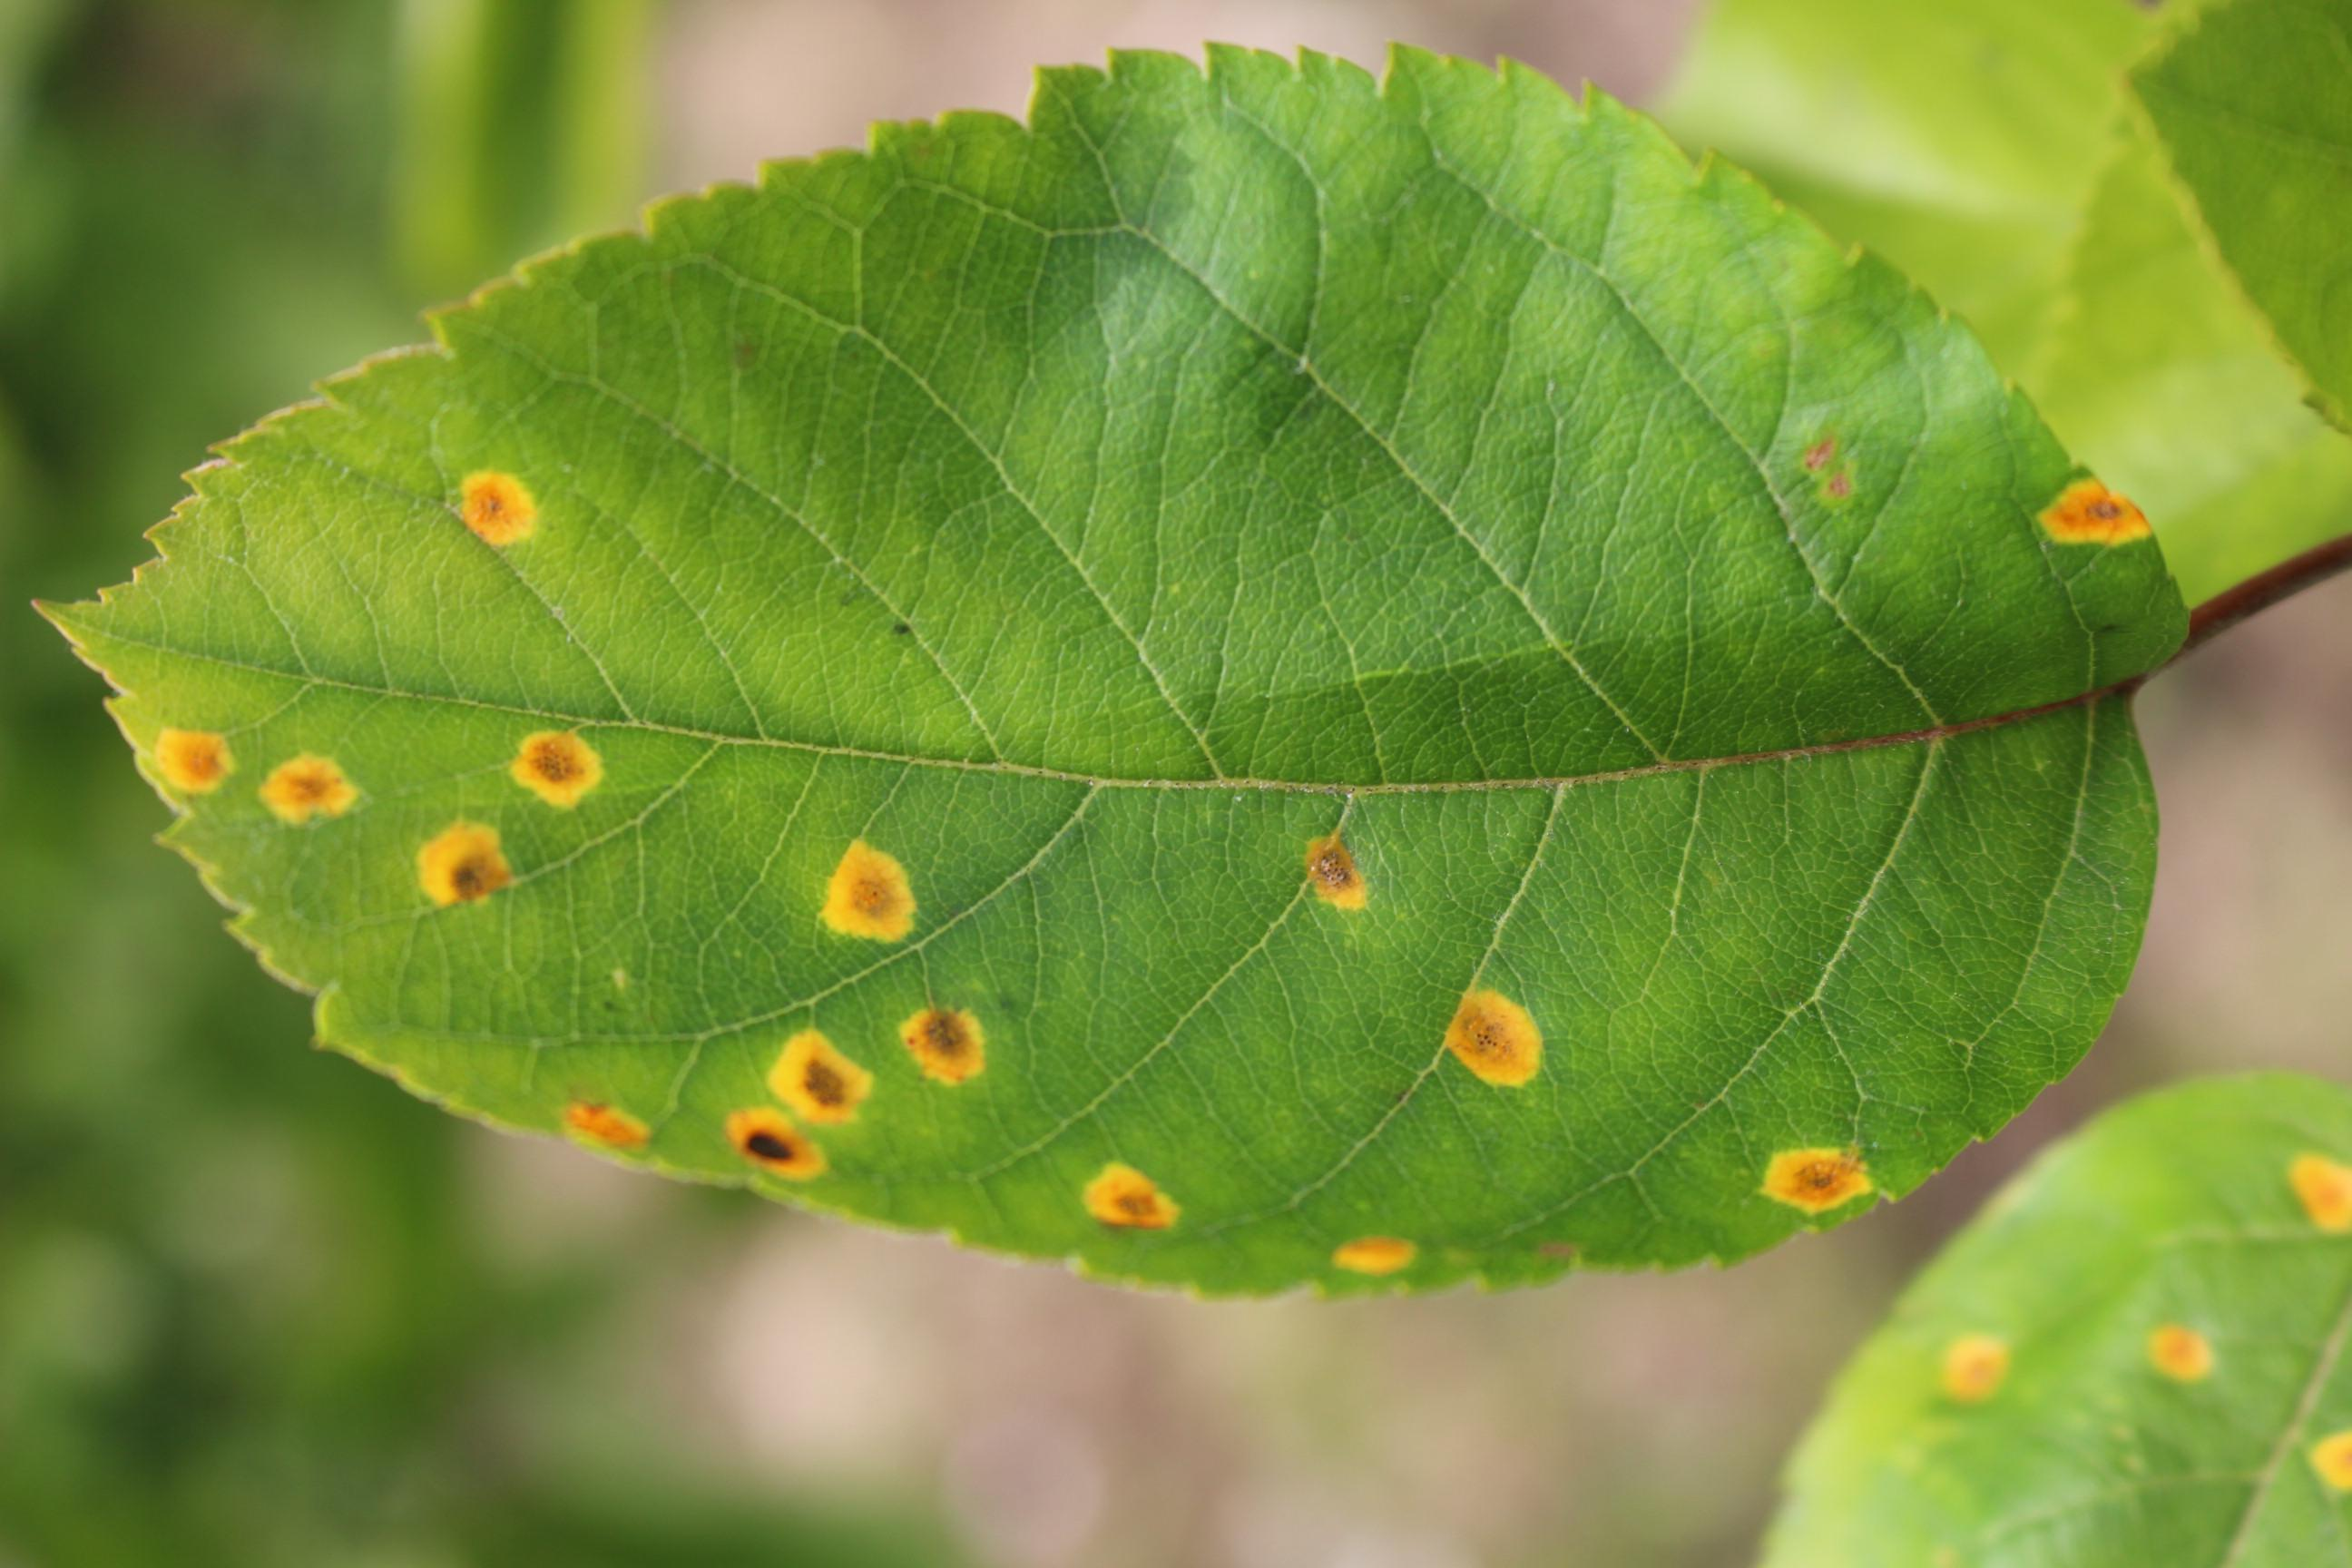

In [3]:
image_path = 'Train/Train/Rust/80f09587dfc7988e.jpg'

with open(image_path, 'rb') as f:
    display.display(display.Image(data=f.read(), width=500))

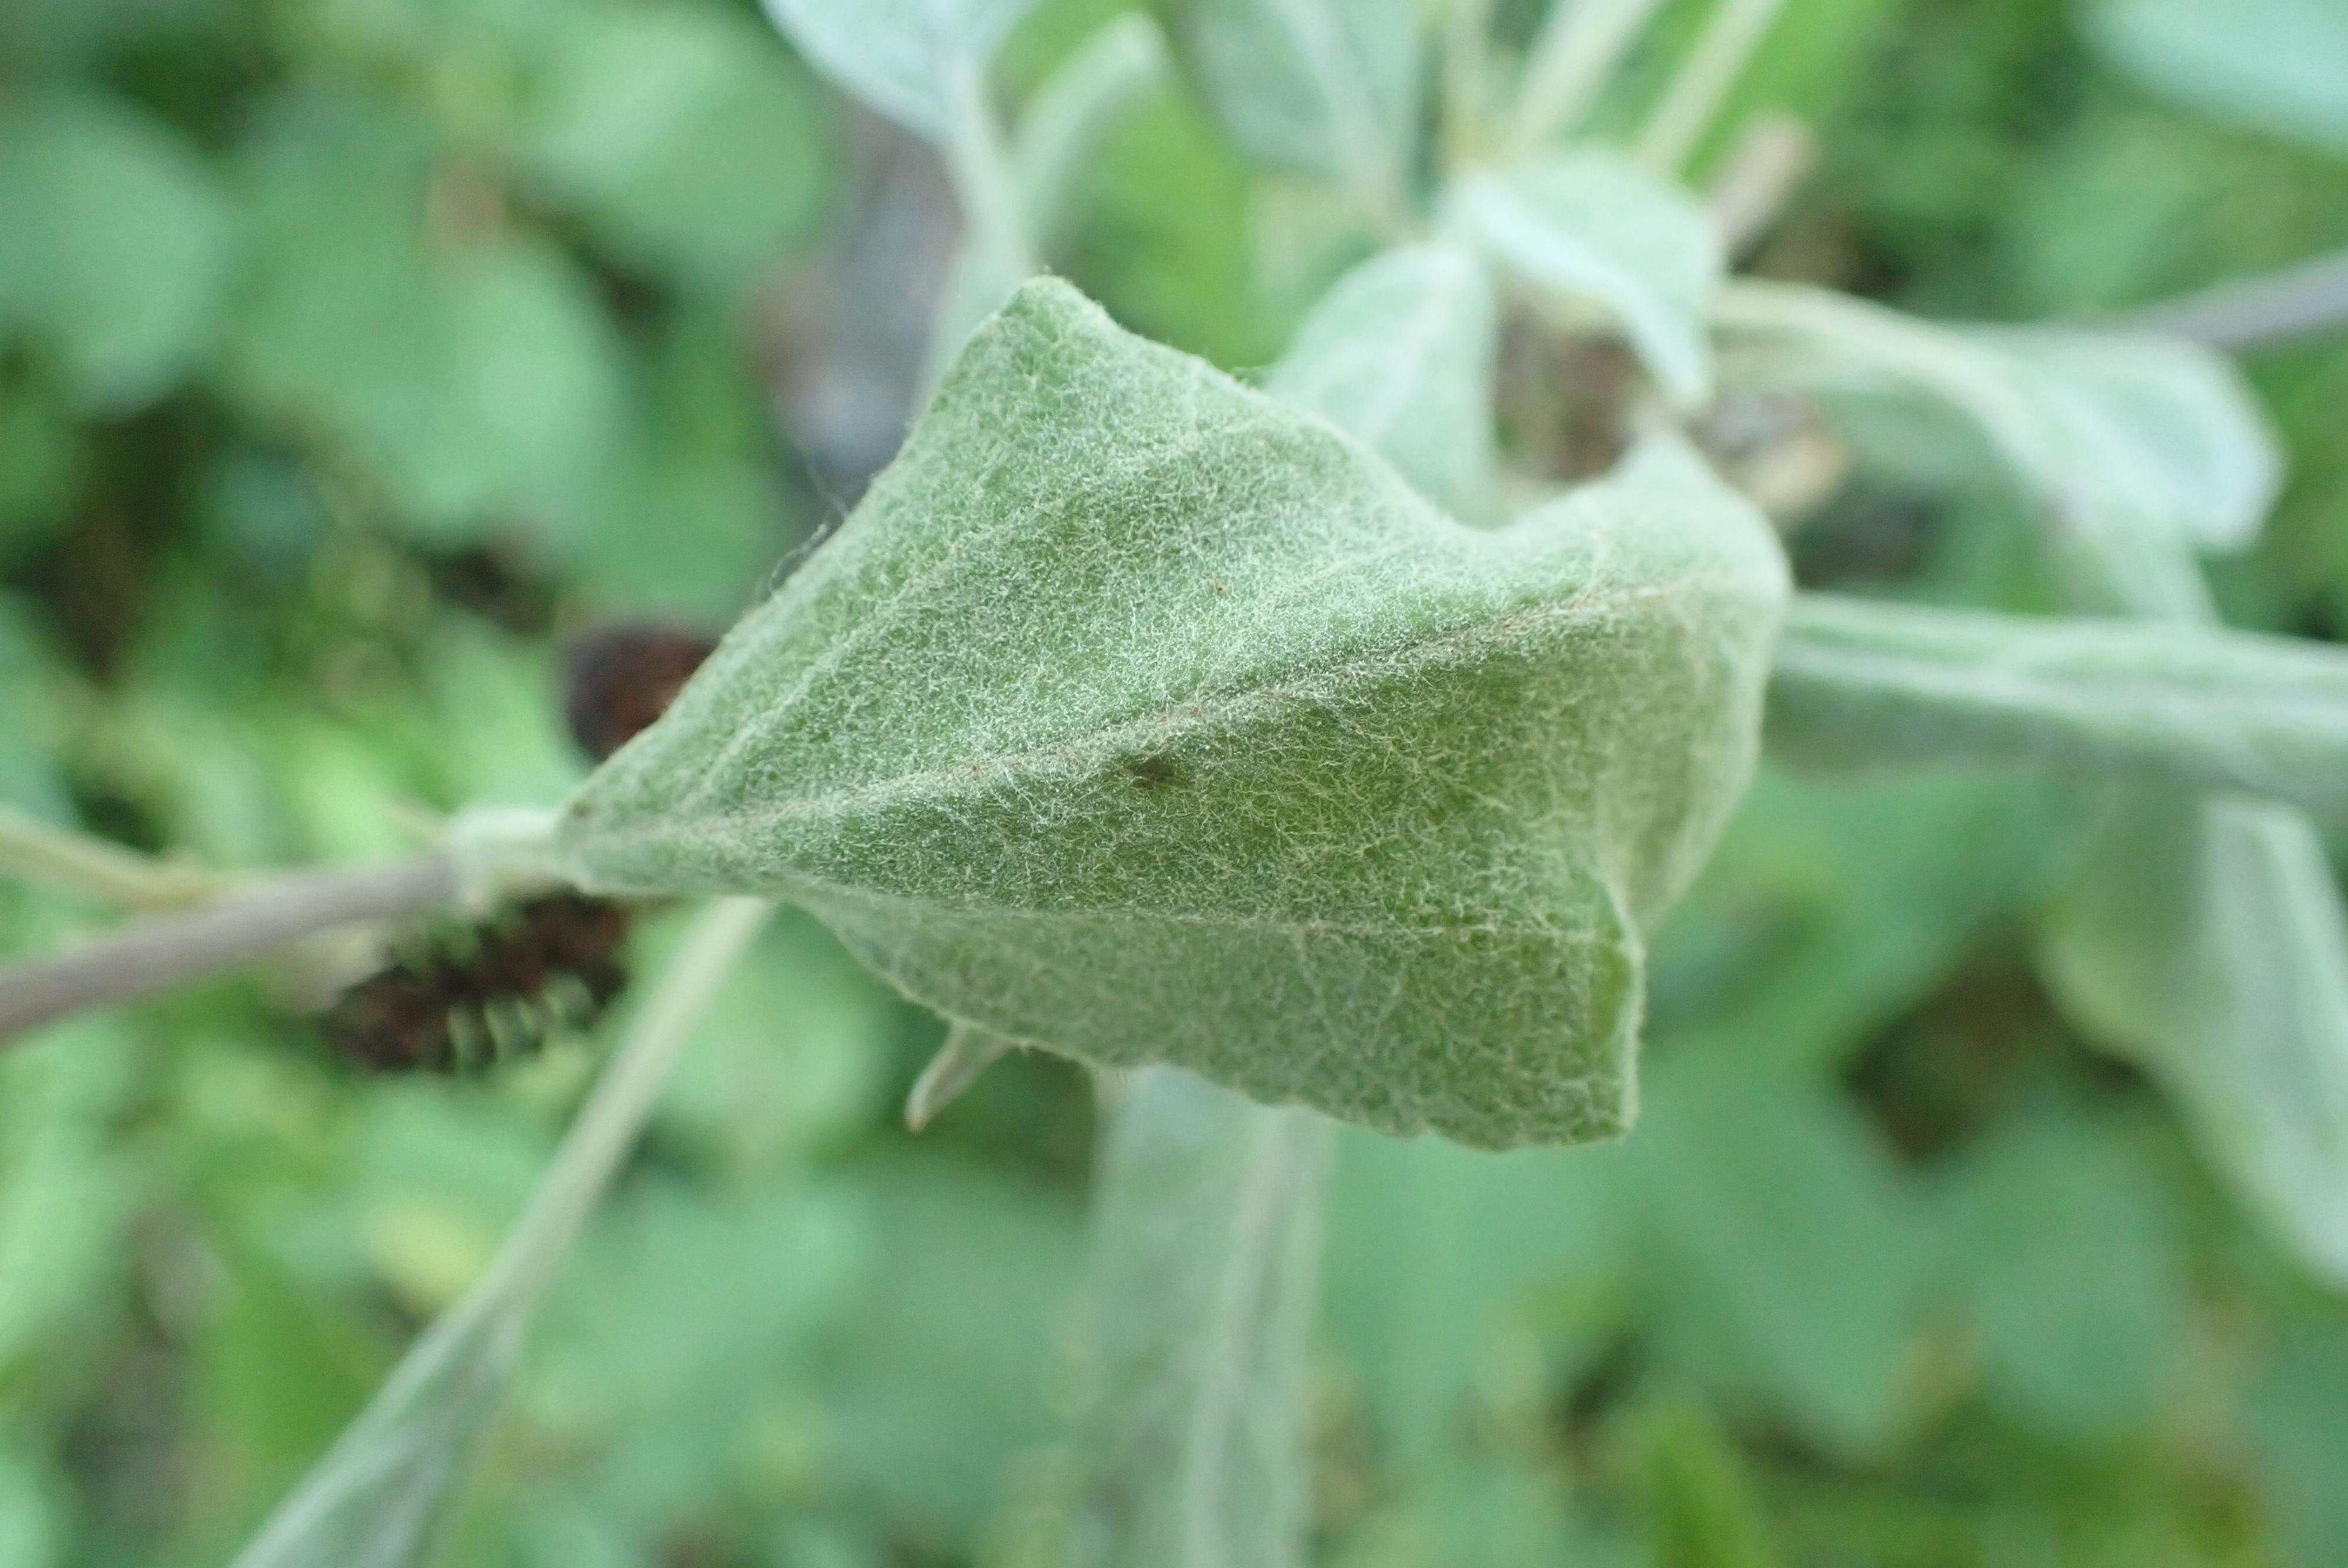

In [4]:
image_path = 'Train/Train/Powdery/8a9ed96e66850ba5.jpg'

with open(image_path, 'rb') as f:
    display.display(display.Image(data=f.read(), width=500))

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=45,        
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    brightness_range=[0.8,1.2],  
    fill_mode='nearest',      
    vertical_flip=True        
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory('Train/Train',
                                                    target_size=(225, 225),
                                                    batch_size=32,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory('Validation/Validation',
                                                        target_size=(225, 225),
                                                        batch_size=32,
                                                        class_mode='categorical')

Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Load ResNet50 with pre-trained weights (excluding top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(225, 225, 3))

# Freeze base model layers initially
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # More efficient than Flatten
x = Dense(256, activation='relu')(x)  # More neurons for complex features
x = Dropout(0.4)(x)  # Dropout to prevent overfitting
output_layer = Dense(3, activation='softmax')(x)  # 3 classes: Healthy, Powdery, Rust

# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Stops early if no improvement
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),  # Reduce LR if accuracy stagnates
    ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max'),  # Save best model
    TensorBoard(log_dir="./logs", histogram_freq=1)  # Optional: Logs for TensorBoard visualization
]

# Train the model
model.fit(
    train_generator,  # Your training data generator
    epochs=10,  # Train for 20 epochs (adjust as needed)
    validation_data=validation_generator,  # Your validation data generator
    callbacks=callbacks  # Apply all callbacks
)

# Recompile the model for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])



NameError: name 'train_generator' is not defined

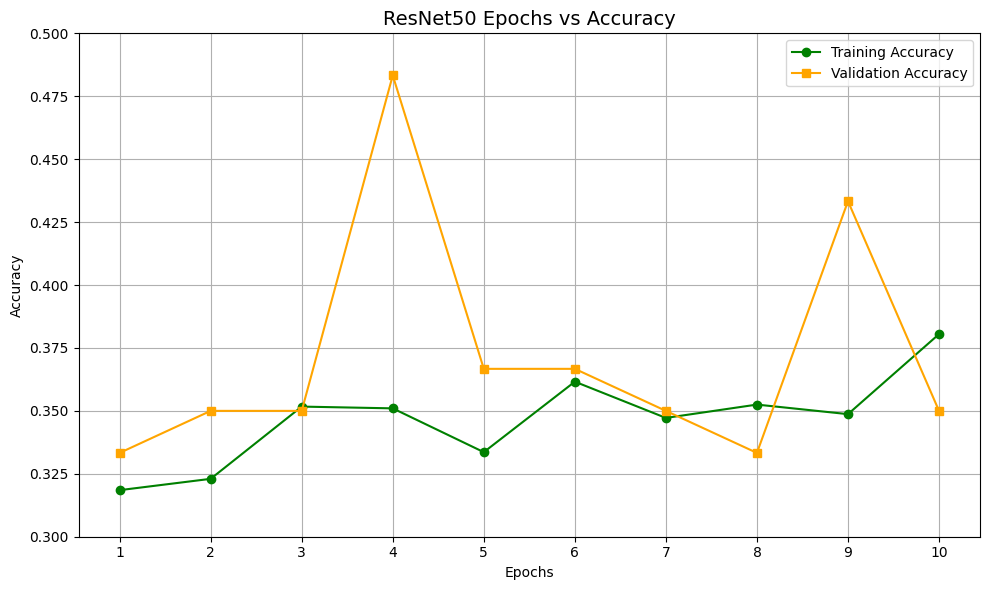

In [2]:
import matplotlib.pyplot as plt

# Epoch numbers
epochs = list(range(1, 11))

# Training and validation accuracy values (from the logs)
train_accuracy = [
    0.3185, 0.3230, 0.3517, 0.3510, 0.3336,
    0.3616, 0.3472, 0.3525, 0.3487, 0.3805
]
val_accuracy = [
    0.3333, 0.3500, 0.3500, 0.4833, 0.3667,
    0.3667, 0.3500, 0.3333, 0.4333, 0.3500
]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, marker='o', label='Training Accuracy', color='green')
plt.plot(epochs, val_accuracy, marker='s', label='Validation Accuracy', color='orange')
plt.title('ResNet50 Epochs vs Accuracy', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.ylim(0.3, 0.5)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
